# Disclamer

Данный проект выполнялся в ограниченные сроки, поэтому некоторые рекомендации учтены не были (относительно отдельного GitHub проекта), на это есть ряд причин:
- Собственный код получился в разы короче, нежели исходная модель cyclegan
- Модель осталась по прежнему работоспособной
- Основной мотивацией оставаться в среде colab - предоставление расчетных мощностей. GitHub проект подразумевает разработку на внутренней оболочке типа PyCharm, а расчеты проводить все равно в colab.



# INITIALIZATION

## Import libraries

In [26]:
import os
import torch
import numpy as np
import random
from torch import nn
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
from abc import ABC, abstractmethod
import functools
from torchsummary import summary
import itertools
import cv2
from tqdm.notebook import tqdm

## Setting Cuda device

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
!nvidia-smi

Sun Jun 27 08:56:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Connecting google disk

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing datasets

In [5]:
!mkdir /content/data

In [7]:
# !cp /content/drive/MyDrive/GAN/CycleGAN/horse2zebra128.zip /content/data/horse2zebra128.zip
!cp /content/drive/MyDrive/GAN/CycleGAN/banana2cucumber128.zip /content/data/banana2cucumber128.zip

In [8]:
# !unzip /content/data/horse2zebra128.zip -d ./data/
!unzip /content/data/banana2cucumber128.zip -d ./data/

Archive:  /content/data/banana2cucumber128.zip
   creating: ./data/banana2cucumber128/
   creating: ./data/banana2cucumber128/.ipynb_checkpoints/
   creating: ./data/banana2cucumber128/banana/
  inflating: ./data/banana2cucumber128/banana/1003499219_c321147242.jpg  
  inflating: ./data/banana2cucumber128/banana/100412966_9a63f65c23.jpg  
  inflating: ./data/banana2cucumber128/banana/100456789_04d13f8e76.jpg  
  inflating: ./data/banana2cucumber128/banana/1004628903_fc21a10cc7.jpg  
  inflating: ./data/banana2cucumber128/banana/1005851110_a1a9533414.jpg  
  inflating: ./data/banana2cucumber128/banana/100809056_7d95315297.jpg  
  inflating: ./data/banana2cucumber128/banana/101206060_8002bb0c2d.jpg  
  inflating: ./data/banana2cucumber128/banana/101746634_3239fc12e2.jpg  
  inflating: ./data/banana2cucumber128/banana/1020368545_06aee19113.jpg  
  inflating: ./data/banana2cucumber128/banana/1021278863_8cd18291ac.jpg  
  inflating: ./data/banana2cucumber128/banana/10250940_14b2bbc4cf.jpg  


## Loading functions

In [9]:
# Denormalization function (to set model export from [-1;1] to [0,1] with origin brightness and contrast)
stats = [(0.5, 0.5, 0.5), (0.25, 0.25, 0.25)] # MEAN AND STD of faces dataset
def denorm(img_tensors):
  image_mean = torch.Tensor(img_tensors.mean(dim=(0,2,3))).unsqueeze(0).unsqueeze(2).unsqueeze(3)
  image_std =torch.Tensor(img_tensors.var(dim=(0,2,3))**(1/2)).unsqueeze(0).unsqueeze(2).unsqueeze(3)
  mean_val = torch.Tensor(stats[0]).unsqueeze(0).unsqueeze(2).unsqueeze(3)
  std_val = torch.Tensor(stats[1]).unsqueeze(0).unsqueeze(2).unsqueeze(3)
  return (img_tensors-image_mean)/image_std*std_val+mean_val

In [10]:
# Plotting results in grid-format
from IPython.display import clear_output
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=4).permute(1, 2, 0))


# CYCLEGAN MODEL

## FAST DATALOADER

In [11]:
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from abc import ABC, abstractmethod


def get_transform():
    transform_list = []
    transform_list += [transforms.ToTensor()]
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

def make_dataset(dir, max_dataset_size=float("inf")):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]

In [12]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
    '.tif', '.TIF', '.tiff', '.TIFF',
]
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

In [13]:
class UnalignedDataset(data.Dataset, ABC):

    def __init__(self, train_A_dir, train_B_dir):

        self.dir_A = train_A_dir  # create a path '/path/to/data/trainA'
        self.dir_B = train_B_dir  # create a path '/path/to/data/trainB'

        self.A_paths = sorted(make_dataset(self.dir_A, 1000))   # load images from '/path/to/data/trainA'
        self.B_paths = sorted(make_dataset(self.dir_B, 1000))    # load images from '/path/to/data/trainB'
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B
        # btoA = 'BtoA'
        input_nc = 3       # get the number of channels of input image
        output_nc = 3      # get the number of channels of output image
        self.transform = get_transform()


    def __getitem__(self, index):

        A_path = self.A_paths[index % self.A_size]  # make sure index is within then range
        index_B = random.randint(0, self.B_size - 1)
        B_path = self.B_paths[index_B]
        # A_img = Image.open(A_path).convert('RGB')
        # B_img = Image.open(B_path).convert('RGB')
        A_img = Image.open(A_path)
        B_img = Image.open(B_path)
        # apply image transformation
        A = self.transform(A_img)
        B = self.transform(B_img)
        return  (A, B)

    def __len__(self):

        return max(self.A_size, self.B_size)

In [14]:
class CustomDatasetDataLoader():
    """Wrapper class of Dataset class that performs multi-threaded data loading"""

    def __init__(self, train_A_dir, train_B_dir,batch_size=1):

        self.dataset = UnalignedDataset(train_A_dir,train_B_dir)
   
        self.dataloader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=True,
            # pin_memory=True,
            num_workers=2)

    def load_data(self):
        return self

    def __len__(self):
        """Return the number of data in the dataset"""
        return min(len(self.dataset), 1000)

    def __iter__(self):
        """Return a batch of data"""
        for i, data in enumerate(self.dataloader):
            if i * 1 >= 1000:
                break
            yield data

Setting train_A and train_B directories

In [15]:
# train_A_dir = '/content/data/horse2zebra128/horse_label/horse'
# train_B_dir = '/content/data/horse2zebra128/zebra_label/zebra'
train_A_dir = '/content/data/banana2cucumber128/banana'
train_B_dir = '/content/data/banana2cucumber128/cucumber'

In [16]:
train_dataloader = CustomDatasetDataLoader(train_A_dir,train_B_dir,batch_size=1)

## GENERATOR


In [17]:
norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
class Generator(nn.Module):
    def __init__(self,image_size=128,inner_channels = 64):
        super().__init__()
        self.generate = nn.Sequential(
        nn.ReflectionPad2d(3),
        nn.Conv2d(3, inner_channels, kernel_size=7, stride=1, padding=0, bias=False),
        nn.InstanceNorm2d(inner_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
        nn.ReLU(),
        # out: 64 x 128 x 128

        nn.Conv2d(inner_channels, inner_channels*2, kernel_size=3, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(inner_channels*2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
        nn.ReLU(),
        # out: 128 x 64 x 64

        nn.Conv2d(inner_channels*2, inner_channels*4, kernel_size=3, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(inner_channels*4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
        nn.LeakyReLU(0.2,inplace=True),
        # out: 256 x 32 x 32

        # nn.Conv2d(inner_channels*4, inner_channels*8, kernel_size=3, stride=2, padding=1, bias=False),
        # nn.InstanceNorm2d(inner_channels*8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
        # nn.LeakyReLU(0.2,inplace=True),
        # # out: 512 x 16 x 16


        # =======resnet_9blocks===========
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        ResnetBlock(256, padding_type='reflect', norm_layer=norm_layer),
        # ========resnet_9blocks===========


        # nn.ConvTranspose2d(inner_channels*8, inner_channels*4, kernel_size=4, stride=2, padding=1, bias=False),
        # # nn.BatchNorm2d(inner_channels*4),
        # nn.LeakyReLU(0.2,inplace=True),
        # out: 256 x 16 x 16
        nn.ConvTranspose2d(inner_channels*4, inner_channels*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        # out: 128 x 32 x 32
        nn.ConvTranspose2d(inner_channels*2, inner_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        # out: 64 x 64 x 64
        nn.ReflectionPad2d((3, 3, 3, 3)),
        nn.Conv2d(inner_channels, 3, kernel_size=7, stride=1, padding=0, bias=False),
        # nn.ConvTranspose2d(inner_channels, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
        # out: 3 x 128 x 128
        )
    def forward(self, x):
        output = self.generate(x)
        return output
        
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout=False, use_bias=False):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

## DISCRIMINATOR WITH PATCHGAN

In [18]:
class Discriminator(nn.Module):

    def __init__(self, ndf=64, n_layers=3):
      super(Discriminator, self).__init__()
        
      norm_layer = nn.BatchNorm2d

      sequence = [nn.Conv2d(3, ndf, 4, 2, 1), nn.LeakyReLU(0.2, True)]

      for n in range(1, n_layers+1):  # gradually increase the number of filters
        if n<3:
          sequence += [
              nn.Conv2d(ndf * (2**(n-1)), ndf * (2**n), 4,2,1, bias=True),
              norm_layer(ndf * (2**n)),
              nn.LeakyReLU(0.2, True)
          ]
        else:
          sequence += [
              nn.Conv2d(ndf * (2**(n-1)), ndf * (2**n), 4,1,1, bias=True),
              norm_layer(ndf * (2**n)),
              nn.LeakyReLU(0.2, True)
          ]


      sequence += [nn.Conv2d(ndf *(2**(n_layers)), 1, 4,1,1)]  # output 1 channel prediction map
      # print(sequence)
      self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


## GAN LOSS

In [19]:

class GANLoss(nn.Module):

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss = nn.MSELoss()

    def get_target_tensor(self, prediction, target_is_real):

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label

        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):

        target_tensor = self.get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)

        return loss

## MODEL INITIALIZATION

In [20]:
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

model = {"G_AB": G_AB, 
         "G_BA": G_BA, 
         "D_A": D_A, 
         "D_B": D_B, 
         }# set models

g_params = itertools.chain(G_AB.parameters(),G_BA.parameters())
d_params = itertools.chain(D_A.parameters(),D_B.parameters())

optimizer = {
    "generator": torch.optim.Adam(g_params, lr=0.0002, betas=(0.5, 0.999)),
    "discriminator": torch.optim.Adam(d_params, lr=0.0002, betas=(0.5, 0.999)),
} 
ganloss = GANLoss('lsgan').to(device)
criterion = {
    "GAN": ganloss,
    "Cycle": nn.L1Loss(),
    "Identity": nn.L1Loss(),
}

## LOADING PRETRAINED MODEL STATE

In [ ]:
model_G_AB = torch.load('/content/drive/MyDrive/GAN/CycleGAN/Models/horse2zebra/G_AB.zip')
model_G_BA = torch.load('/content/drive/MyDrive/GAN/CycleGAN/Models/horse2zebra/G_BA.zip')
model_D_A = torch.load('/content/drive/MyDrive/GAN/CycleGAN/Models/horse2zebra/D_A.zip')
model_D_B = torch.load('/content/drive/MyDrive/GAN/CycleGAN/Models/horse2zebra/D_B.zip')
model['G_AB'].load_state_dict(model_G_AB)
model['G_BA'].load_state_dict(model_G_BA)
model['D_A'].load_state_dict(model_D_A)
model['D_B'].load_state_dict(model_D_B)

## TRAIN

Logs

In [21]:
loss_ga = []
loss_da = []
loss_cycle_a = []
loss_idt_a = []

loss_gb = []
loss_db = []
loss_cycle_b = []
loss_idt_b = []

In [30]:
from tqdm import tqdm

In [34]:
def set_requires_grad(net_list, requires_grad_mode):
  for net in net_list:
    for param in net.parameters():
        param.requires_grad = requires_grad_mode


def train_combined(epochs=100):
  j = 0
  st = 0
  lambda_idt = 0.5
  lambda_A = 10
  lambda_B = 10
  
  for i in tqdm(range(epochs),leave=True,position=0):
    # for A_batch, _ in tqdm(A_dataloader, leave=False,position=0):
    for real_A, real_B in tqdm(train_dataloader, leave=False,position=0):
      # B_batch, _ = next(iter(B_dataloader))
      # real_A, real_B  = real_A
      real_A, real_B = real_A.to(device), real_B.to(device)
      #GETTING GENERATED AND RECONSTRUCTED IMAGES

      fake_B = model['G_AB'](real_A)  # G_A(A)
      rec_A = model['G_BA'](fake_B)
      fake_A = model['G_BA'](real_B)
      rec_B = model['G_AB'](fake_A)

      #TURNING OFF GRADIENTS OF D_A AND D_B
      set_requires_grad([model['D_A'],model['D_B']],False)

      #TRAINING GENERATORS A_B AND B_A
      optimizer['generator'].zero_grad()
      idt_A = model['G_AB'](real_B)
      idt_B = model['G_BA'](real_A)
      loss_idt_A = criterion['Identity'](idt_A,real_B)*lambda_B*lambda_idt
      
      loss_idt_B = criterion['Identity'](idt_B,real_A)*lambda_A*lambda_idt

      loss_G_A = criterion['GAN'](model['D_A'](fake_B), True)
      loss_G_B = criterion['GAN'](model['D_B'](fake_A), True)

      loss_cycle_A = criterion['Cycle'](rec_A, real_A) * lambda_A
      loss_cycle_B = criterion['Cycle'](rec_B, real_B) * lambda_B

      loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
      
      loss_G.backward()


      optimizer['generator'].step()


      #TURNING ON GRADIENTS OF D_A AND D_B
      set_requires_grad([model['D_A'],model['D_B']],True)
      optimizer['discriminator'].zero_grad()


      #TRAINING DISCRIMINATOR A
      
      # ON REAL IMAGES
      pred_real = model['D_A'](real_B)
      loss_D_A_real = criterion['GAN'](pred_real, True)
      # ON FAKE IMAGES
      pred_fake = model['D_A'](fake_B.detach())
      loss_D_A_fake = criterion['GAN'](pred_fake, False)
      # Combined loss and calculate gradients
      loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
      loss_D_A.backward()

      #TRAINING DISCRIMINATOR B

      # ON REAL IMAGES
      pred_real = model['D_B'](real_A)
      loss_D_B_real = criterion['GAN'](pred_real, True)
      # ON FAKE IMAGES
      pred_fake = model['D_B'](fake_A.detach())
      loss_D_B_fake = criterion['GAN'](pred_fake, False)
      # Combined loss and calculate gradients
      loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
      loss_D_B.backward()

      optimizer['discriminator'].step()

      ## PLOT INTERMEDIATE RESULTS AND SAVING CHECKPOINTS
      j+=1
      st+=1
      if st == 5000:
        st=0
        torch.save(model['G_AB'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/temp/G_AB.zip')
        torch.save(model['G_BA'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/temp/G_BA.zip')
        torch.save(model['D_A'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/temp/D_A.zip')
        torch.save(model['D_B'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/temp/D_B.zip')

      
                    
      # ========
      if j == 100:
        j=0
        images_A = torch.Tensor()
        images_B = torch.Tensor()
        for _ in range(4):
          real_A, real_B = next(iter(train_dataloader))
          images_A = torch.cat((images_A,real_A))
          images_B = torch.cat((images_B,real_B))
        
        AtoB = model['G_AB'](images_A.to(device))
        BtoA = model['G_BA'](images_B.to(device))
        images = torch.Tensor().to(device)
        images = torch.cat((images_A,AtoB.cpu(),images_B,BtoA.cpu())).detach()
        images = denorm(images)
        clear_output(wait=True)
        show_images(images)
        plt.show()
      if j % 100 == 0:
        loss_ga.append(loss_G_A)
        loss_da.append(loss_D_A)
        loss_cycle_a.append(loss_cycle_A)
        loss_idt_a.append(loss_idt_A)

        loss_gb.append(loss_G_B)
        loss_db.append(loss_D_B)
        loss_cycle_b.append(loss_cycle_B)
        loss_idt_b.append(loss_idt_B)


        print('Epoch {}/{}, loss_G_A: {:4f}, loss_D_A: {:4f}, loss_cycle_A: {:4f}, loss_idt_A: {:4f}, loss_G_B: {:4f}, loss_D_B: {:4f}, loss_cycle_B: {:4f}, loss_idt_B: {:4f}'.format(
                                                  i,
                                                 epochs,
                                                 loss_G_A,
                                                 loss_D_A, 
                                                 loss_cycle_A,
                                                 loss_idt_A,
                                                 loss_G_B,
                                                 loss_D_B, 
                                                 loss_cycle_B,
                                                 loss_idt_B 
                                                 )
        )
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


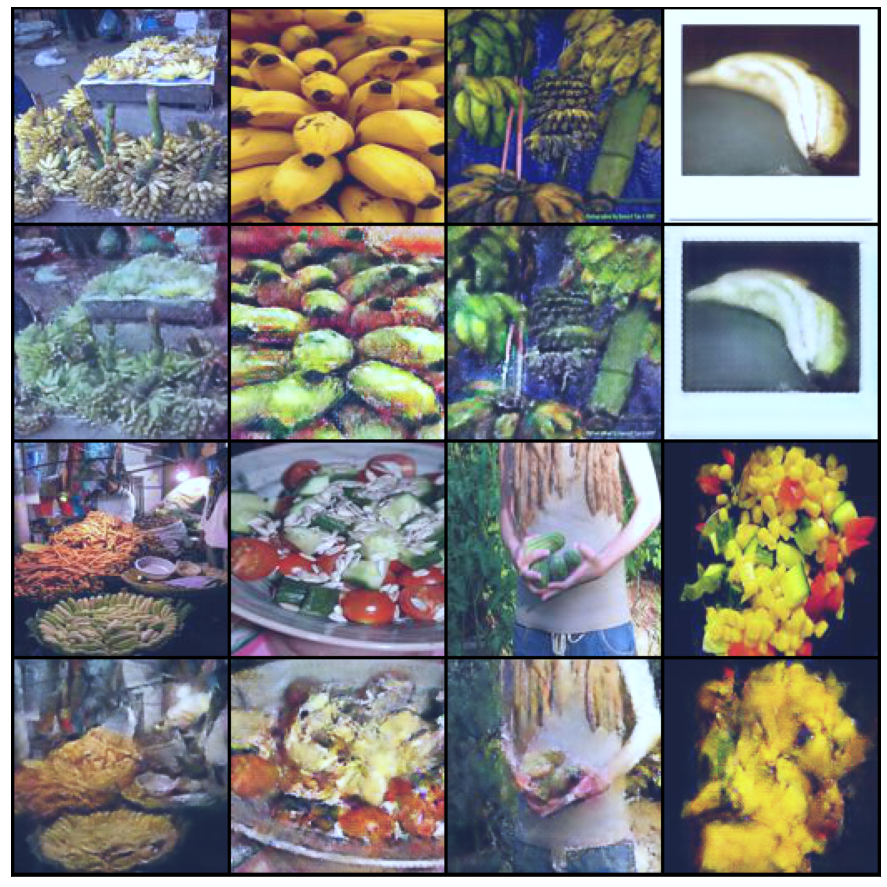

 84%|████████▎ | 749/896 [01:56<01:14,  1.98it/s]

Epoch 87/100, loss_G_A: 0.546027, loss_D_A: 0.104830, loss_cycle_A: 0.759136, loss_idt_A: 0.483037, loss_G_B: 0.498540, loss_D_B: 0.082863, loss_cycle_B: 0.868210, loss_idt_B: 0.350245


 93%|█████████▎| 834/896 [02:07<00:08,  7.41it/s]

KeyboardInterrupt: ignored

In [35]:
train_combined()

## Plot losses

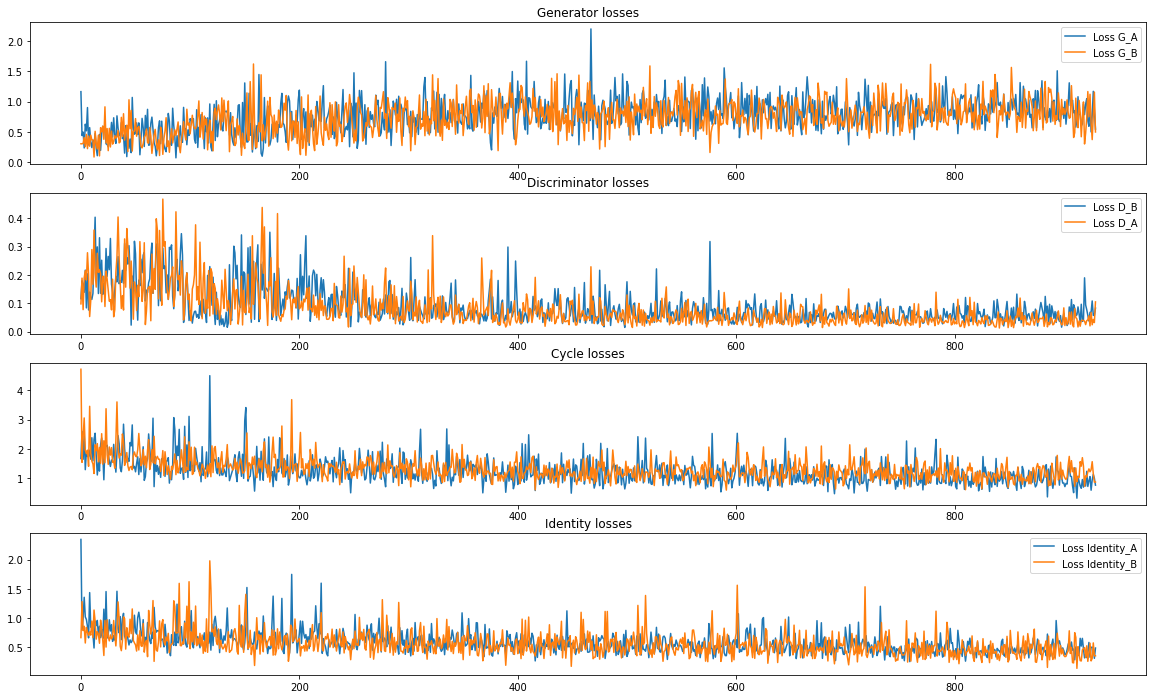

In [39]:
plt.figure(figsize=(20,12))
plt.subplot(4,1,1)
plt.title('Generator losses')
plt.plot(loss_ga,label='Loss G_A')
plt.plot(loss_gb,label='Loss G_B')
plt.legend()
plt.subplot(4,1,2)
plt.title('Discriminator losses')
plt.plot(loss_db,label='Loss D_B')
plt.plot(loss_da,label='Loss D_A')
plt.legend()

plt.subplot(4,1,3)
plt.title('Cycle losses')

plt.plot(loss_cycle_a,label='Loss Cycle_A')
plt.plot(loss_cycle_b,label='Loss Cycle_B')

plt.subplot(4,1,4)
plt.title('Identity losses')
plt.plot(loss_idt_a,label='Loss Identity_A')
plt.plot(loss_idt_b,label='Loss Identity_B')
plt.legend()



## Loading/Saving logs

In [40]:
logs = {'Loss G_A':loss_ga,
        'Loss D_A':loss_da,
        'Loss G_B':loss_gb,
        'Loss D_B':loss_db,
        'Loss Cycle_B':loss_cycle_b,
        'Loss Identity_B':loss_idt_b,
        'Loss Cycle_A':loss_cycle_a,
        'Loss Identity_A':loss_idt_a,   
        }

In [42]:
import pickle


with open('/content/drive/MyDrive/GAN/CycleGAN/logs/banana_logs.pickle', 'wb') as handle:
    pickle.dump(logs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/Semantic_segmentation/logs.pickle', 'rb') as handle:
#     Model_metrics = pickle.load(handle)

## Manual saving model

In [43]:
torch.save(model['G_AB'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/banana2cucumber/G_AB.zip')
torch.save(model['G_BA'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/banana2cucumber/G_BA.zip')
torch.save(model['D_A'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/banana2cucumber/D_A.zip')
torch.save(model['D_B'].state_dict(), '/content/drive/MyDrive/GAN/CycleGAN/Models/banana2cucumber/D_B.zip')